In [1]:
import queueing_process as qp
import matplotlib.pyplot as plt
import imageio
import scipy.stats as ss
import seaborn as sns
import sys
import numpy as np
import numpy.random as npr
sns.set()

# Delay distributions

In [2]:
def symptom_onset_to_joining_queue():
    return round(npr.gamma(
        shape=2.62**2/2.38**2,
        scale=2.38**2/2.62))

Text(0.5, 1.0, 'Symptom onset to attempting to get a test (1000 samples)')

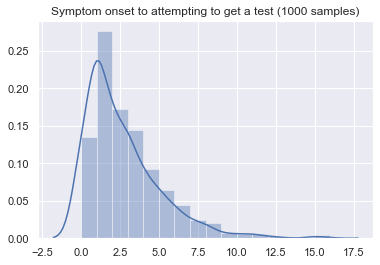

In [3]:
x = [symptom_onset_to_joining_queue() for i in range(1000)]
sns.distplot(x, bins = int(max(x) - min(x)))
plt.title('Symptom onset to attempting to get a test (1000 samples)')

In [4]:
def test_processing_delay_dist():
    return round(ss.gamma.rvs(a=4.941424, scale=0.266155))

Text(0.5, 1.0, 'Test processing delay distribution (1000 samples)')

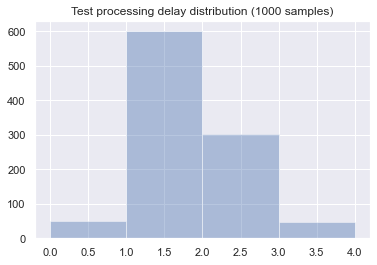

In [5]:
x = [test_processing_delay_dist() for i in range(1000)]
sns.distplot(x, bins = int(max(x) - min(x)), kde = False)
plt.title('Test processing delay distribution (1000 samples)')

# Model set up

In [6]:
# Epidemic incidence (equates to demand)
days_to_simulate = 70
growth_rate = 0.07
starting_infections = 200
def incidence(time):
    incidence_out = starting_infections*(np.exp(growth_rate*time) - np.exp(growth_rate*(time-1)))
    return int(round(incidence_out))
demand = [incidence(time) for time in range(days_to_simulate)] 

# Testing capacity
initial_capacity = 100
daily_capacity_increase = 10
capacity = [initial_capacity + daily_capacity_increase * 10 for time in range(days_to_simulate)]

The next chunk is a little slow because it is responsible for preallocating a lot of memory.

In [7]:
%%time
my_queue = qp.queueing_process(
    days_to_simulate = days_to_simulate,
    capacity = capacity,
    demand = demand,
    symptom_onset_to_joining_queue_dist = symptom_onset_to_joining_queue,
    test_processing_delay_dist = test_processing_delay_dist
)

Wall time: 114 ms


The chunk runs the model

In [8]:
%%time
my_queue.run_simulation()

Wall time: 1.39 sogress: 100%


Text(0.5, 0, 'Time of joining queue (days)')

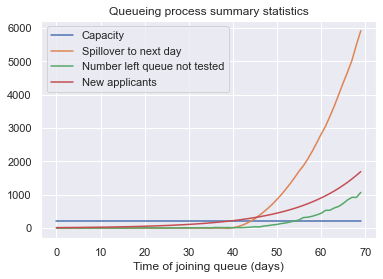

In [9]:
plt.plot('time','capacity', data = my_queue.queue_info)
#plt.plot('time','capacity_exceeded_by', data = my_queue.queue_info)
plt.plot('time','spillover_to_next_day', data = my_queue.queue_info)
plt.plot('time','number_left_queue_not_tested', data = my_queue.queue_info)
plt.plot('time','new_applicants', data = my_queue.queue_info)
plt.legend(['Capacity',
            #'Amount capacity exceeded by',
            'Spillover to next day',
            'Number left queue not tested',
            'New applicants'])
plt.title('Queueing process summary statistics')
plt.xlabel('Time of joining queue (days)')

(0.0, 1.1)

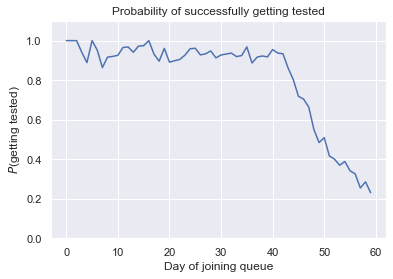

In [10]:
plt.plot([my_queue.get_prob_getting_tested(time) for time in range(days_to_simulate - 10)])
plt.title('Probability of successfully getting tested')
plt.xlabel('Day of joining queue')
plt.ylabel('$P$(getting tested)')
plt.ylim(0,1.1)

In [11]:
def draw_histogram_2(time):

    # get the delay data
    delays = my_queue.get_delays_for(time_entered_queue = time,
                                     delay_from_column = 'symptom_onset',
                                     delay_to_column = 'time_received_result')
    
    # create a figure
    fig, ax = plt.subplots(figsize=(10,5))

    # work out how many bins we need
    bin_count = int(delays.max() - delays.min())
    
    # create the plot
    sns.distplot(delays, ax = ax, bins = bin_count)
    plt.title(f'Symptom onset to receiving result distribution on day {time}\n Mean = {round(delays.mean(), ndigits = 2)}, Variance = {round(delays.var(), ndigits = 2)}')
    plt.xlim(0,14)
    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image

<ipython-input-11-b58905612363>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10,5))
<ipython-input-11-b58905612363>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10,5))
<ipython-input-11-b58905612363>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,

ValueError: cannot convert float NaN to integer

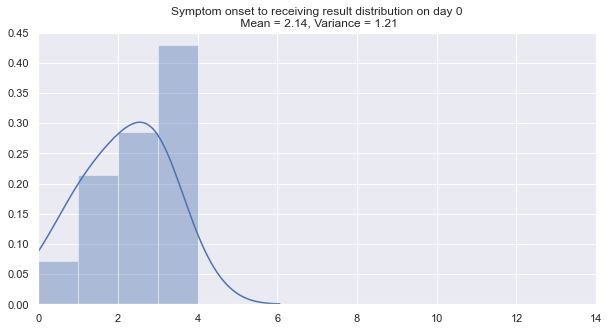

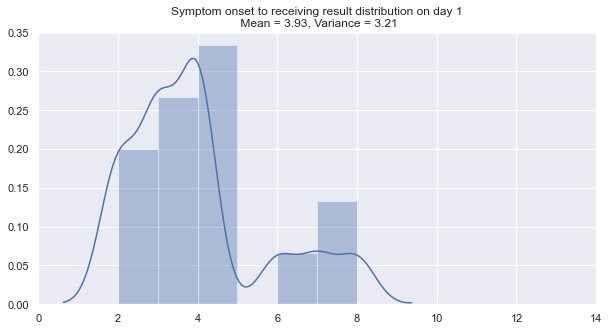

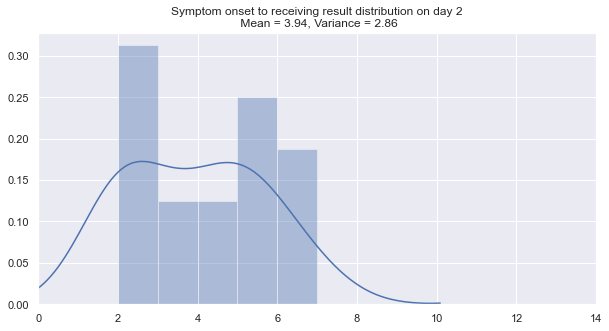

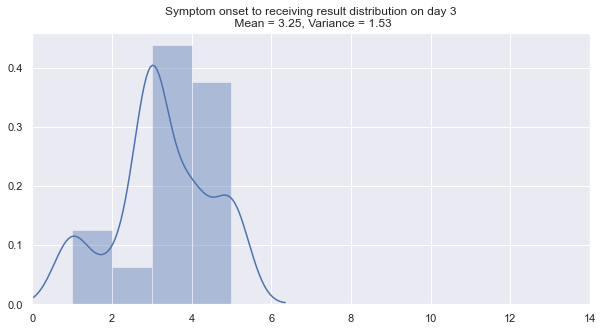

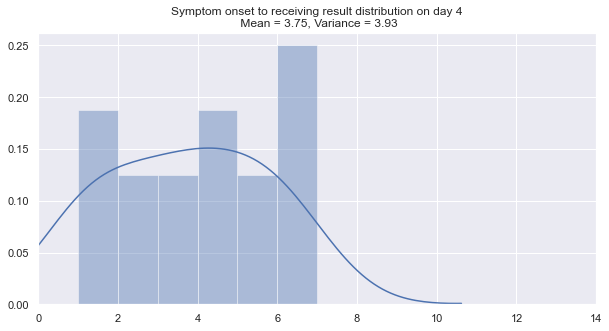

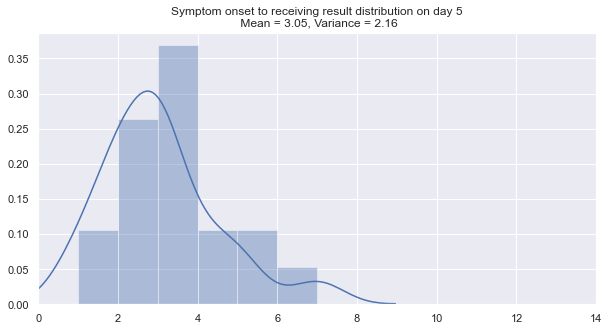

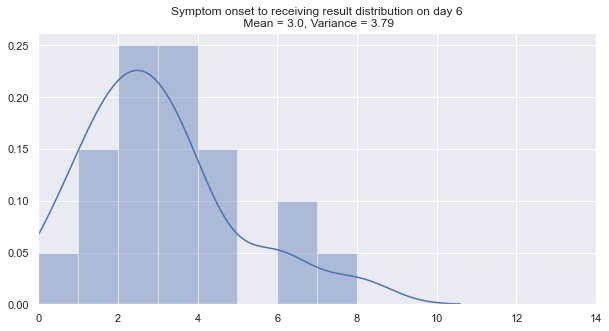

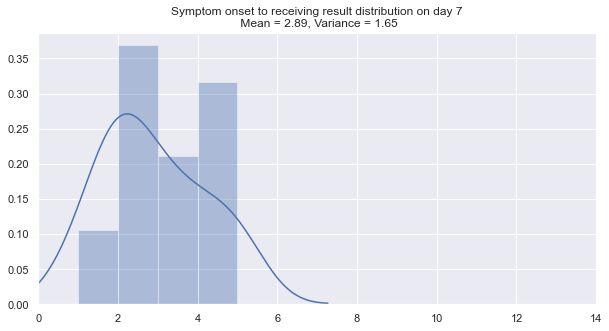

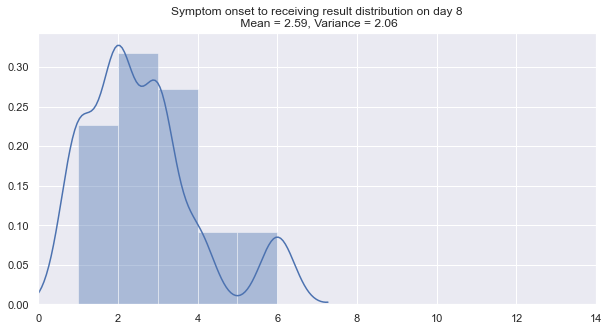

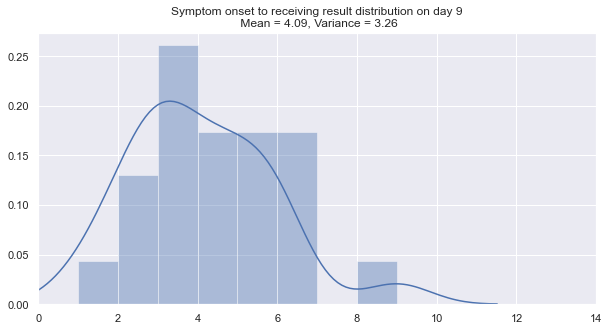

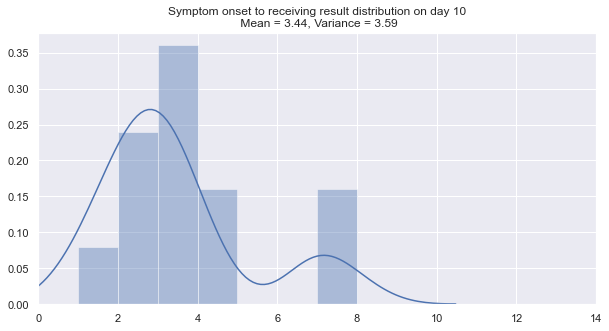

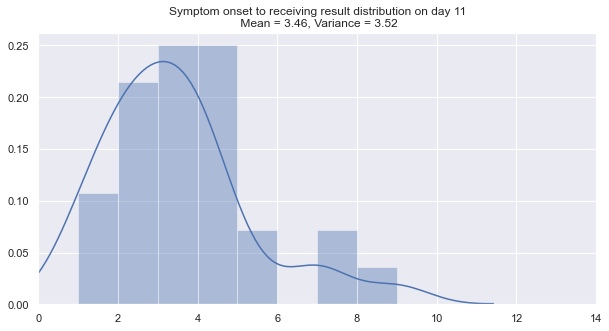

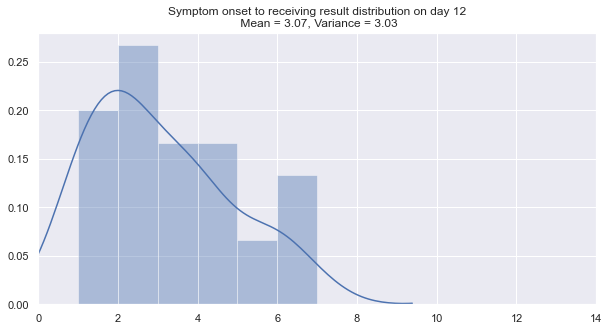

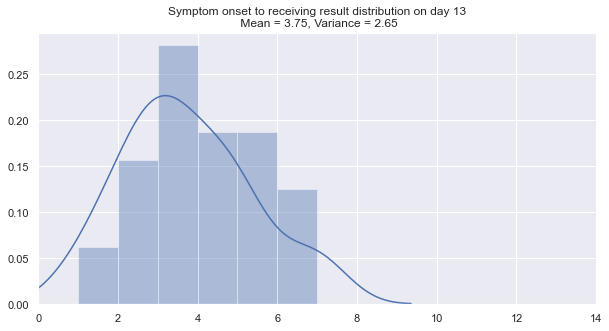

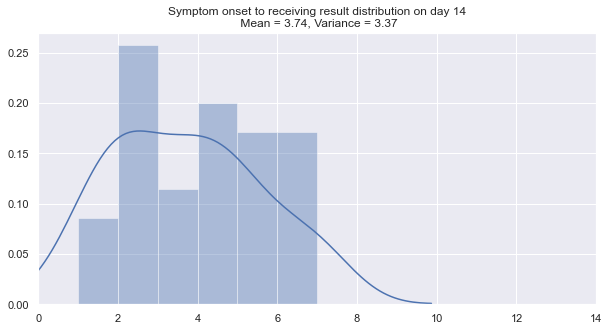

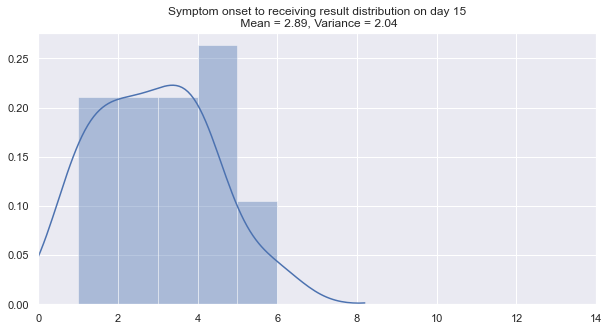

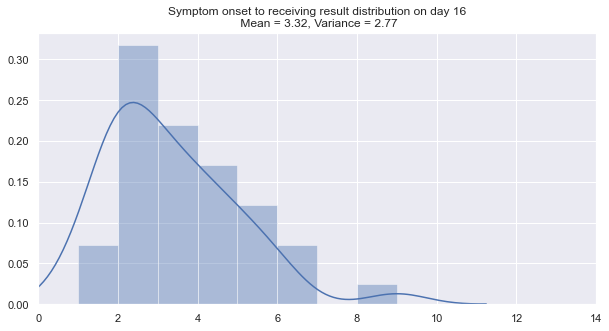

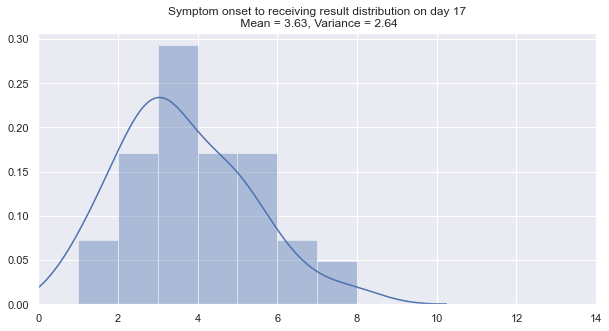

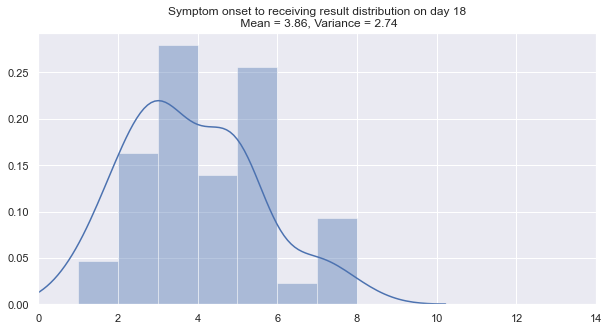

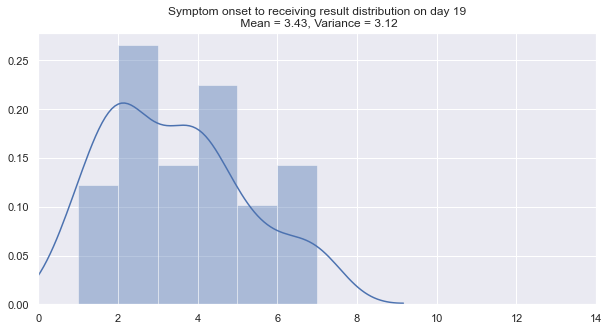

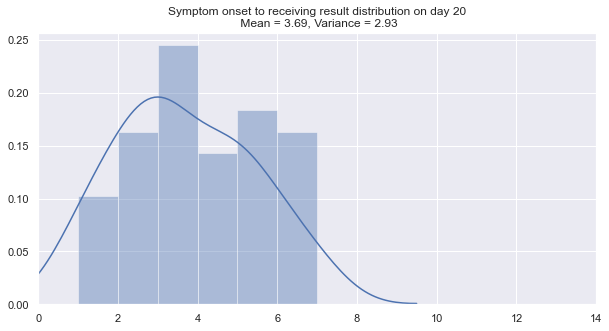

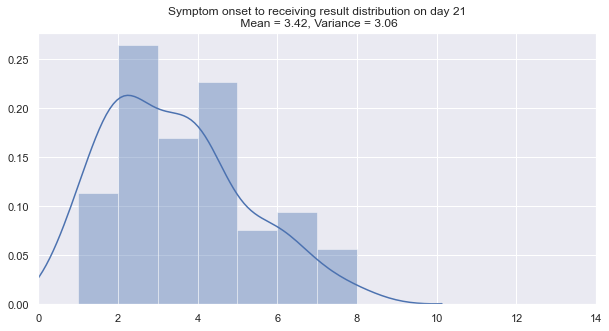

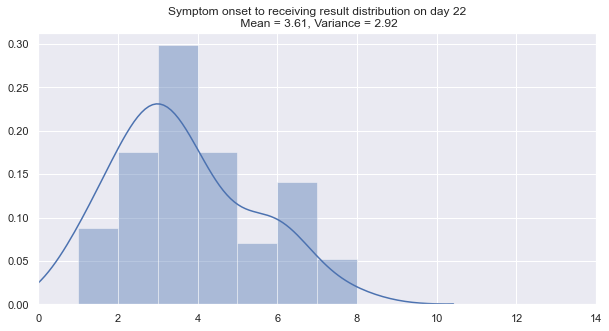

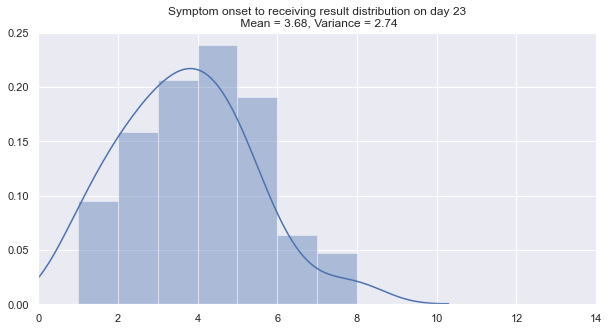

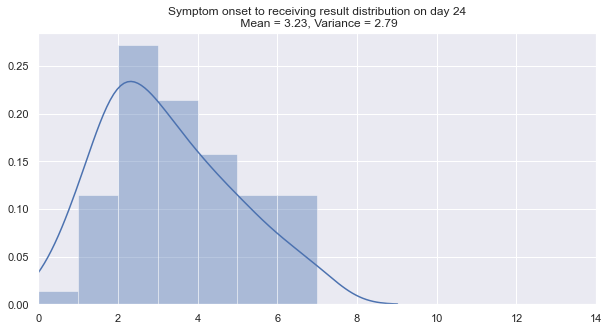

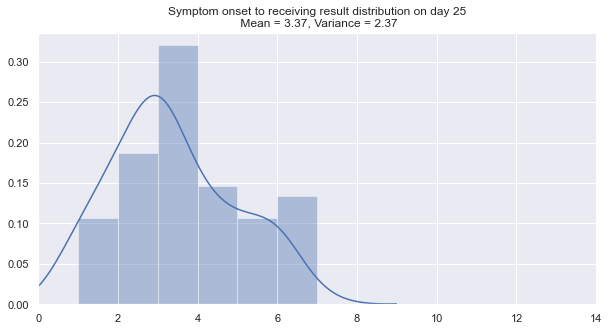

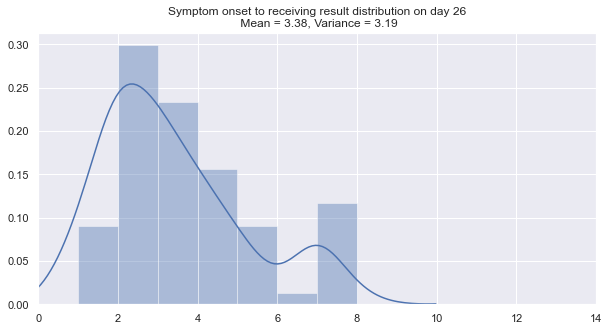

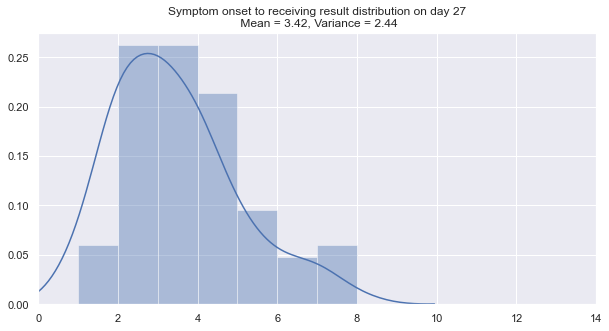

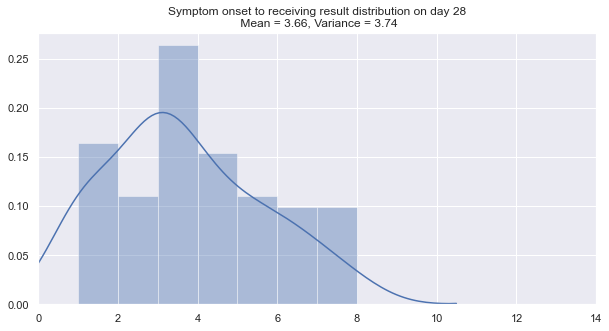

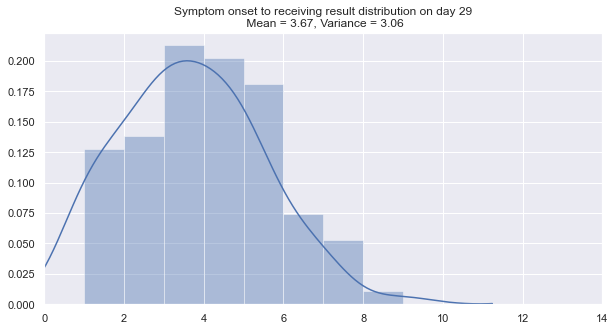

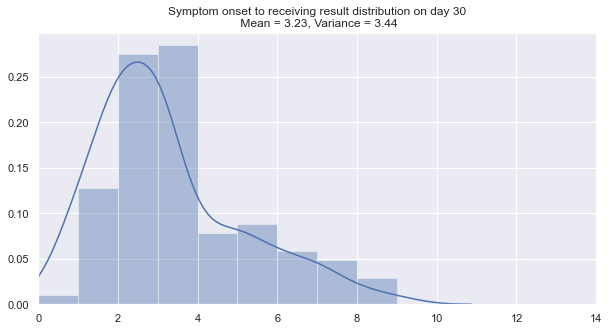

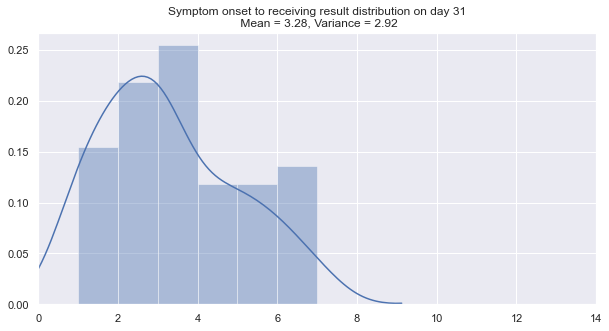

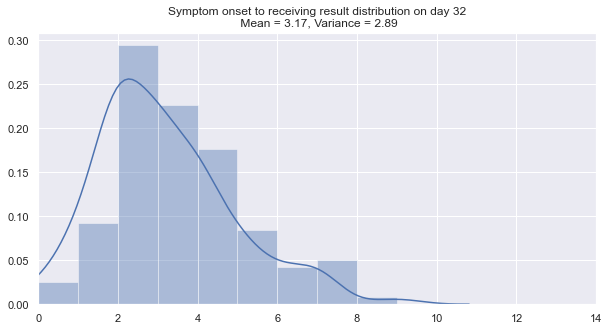

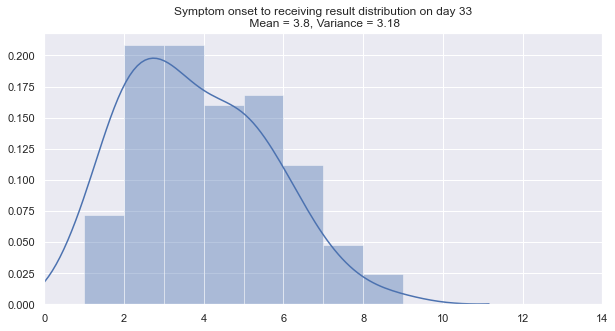

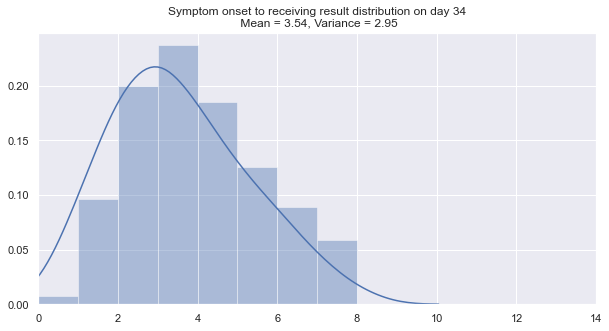

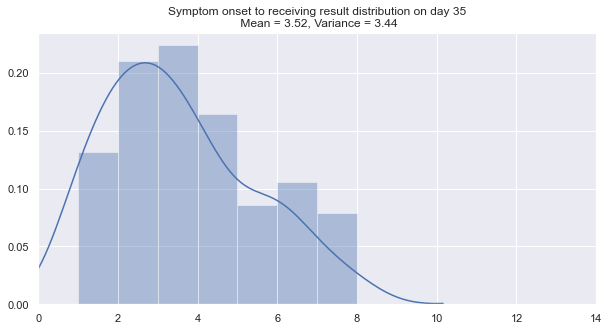

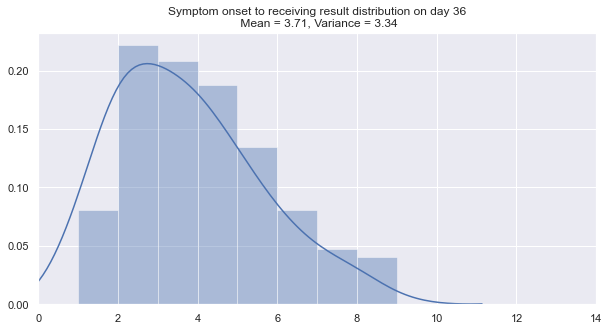

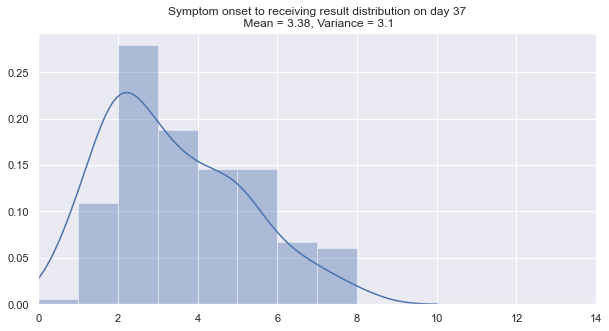

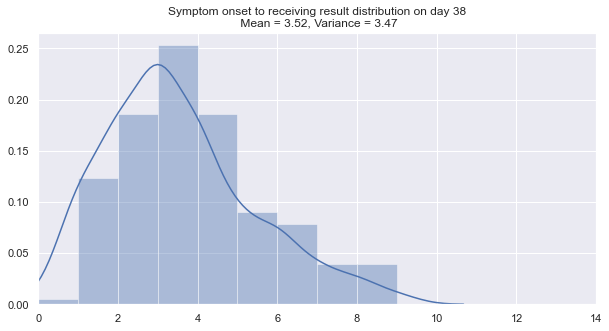

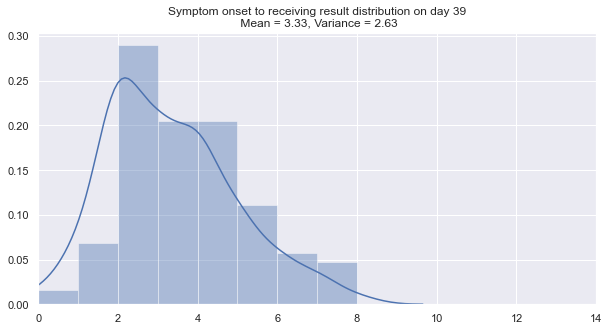

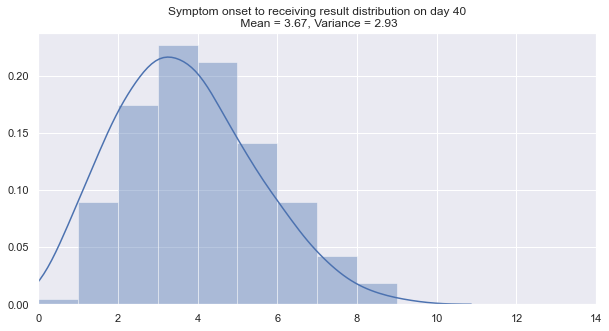

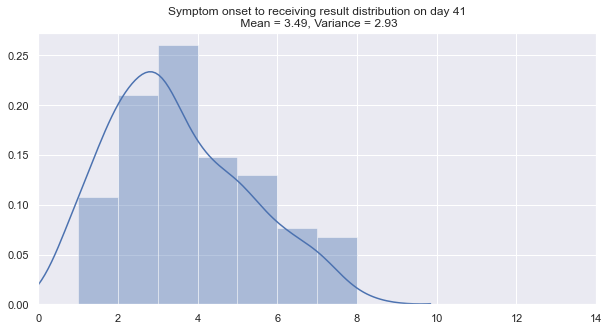

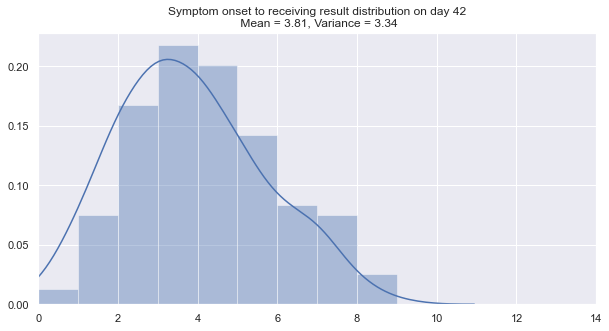

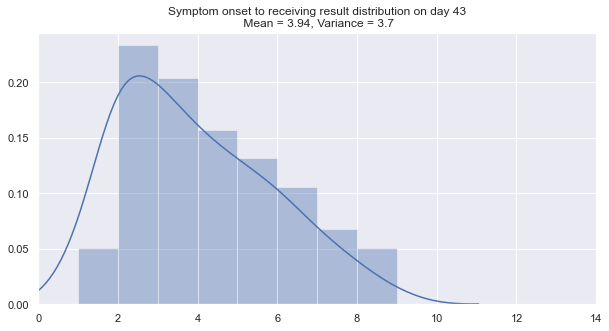

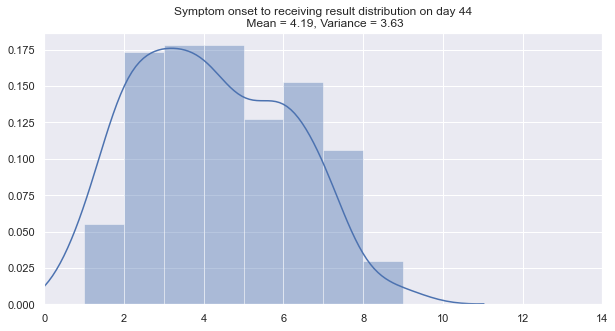

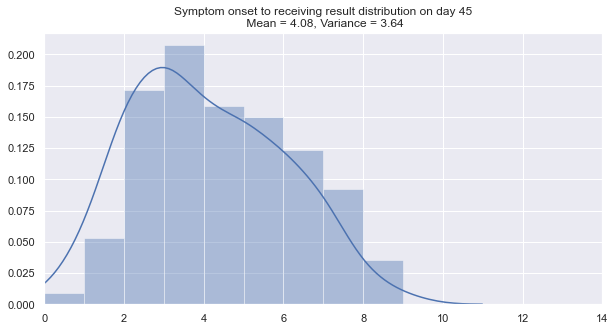

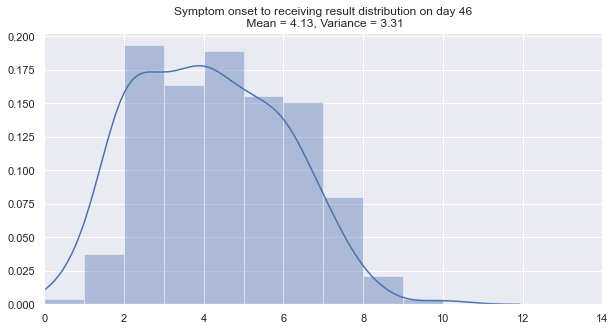

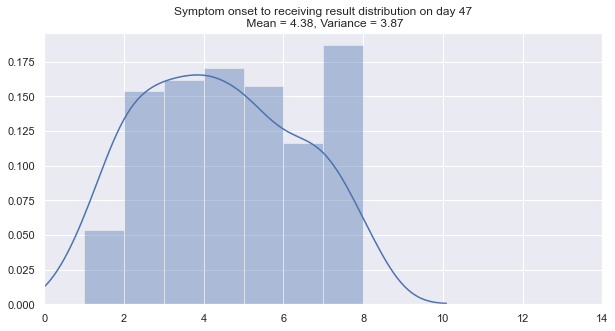

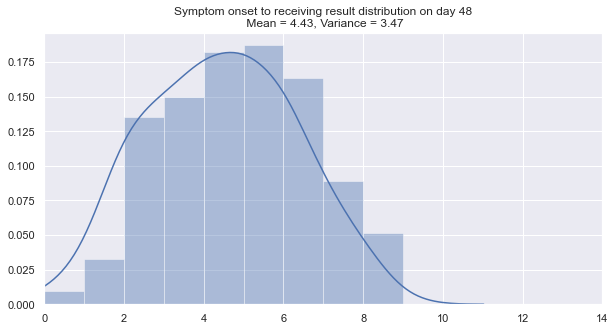

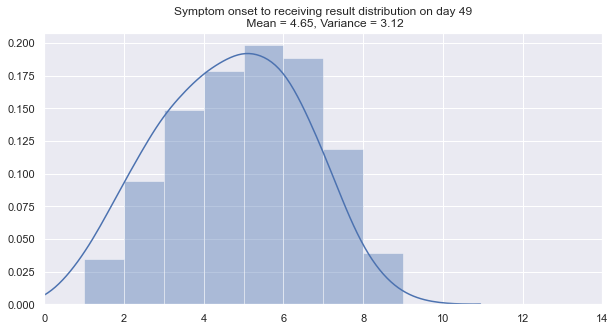

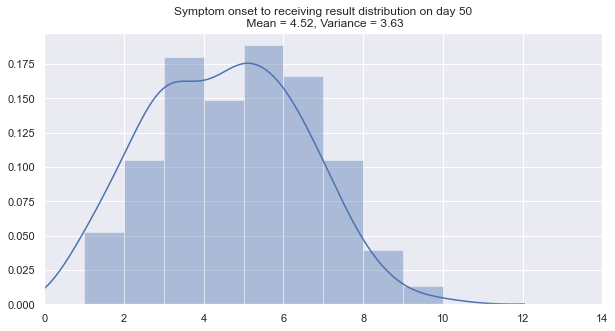

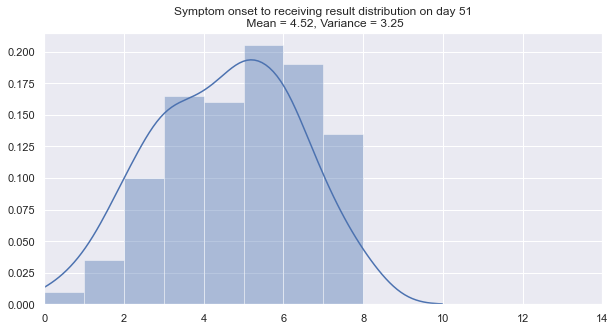

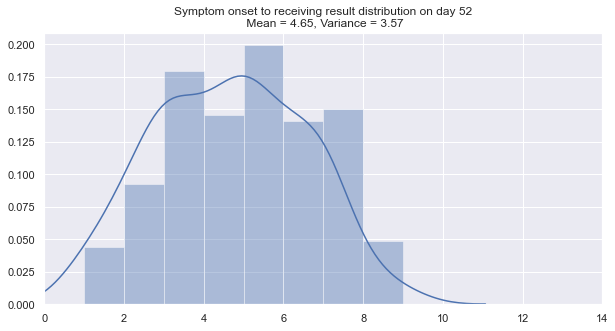

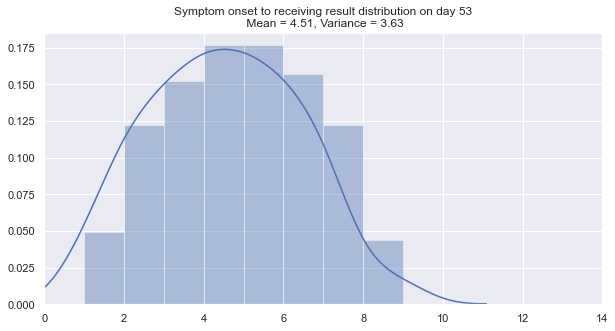

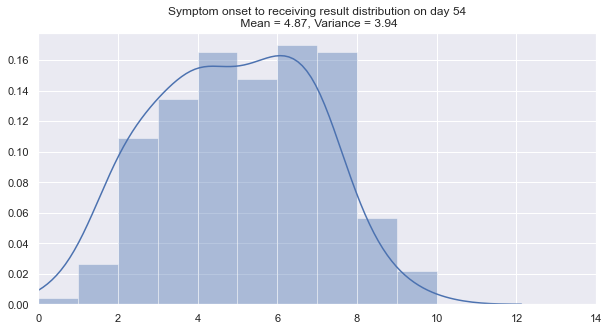

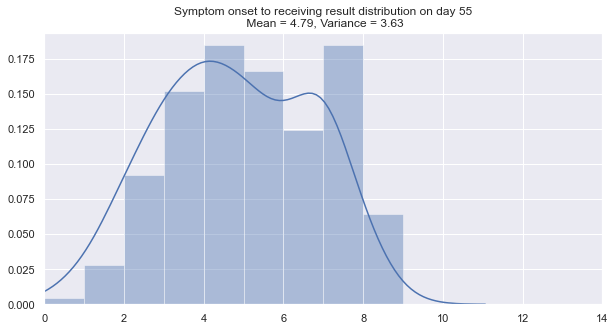

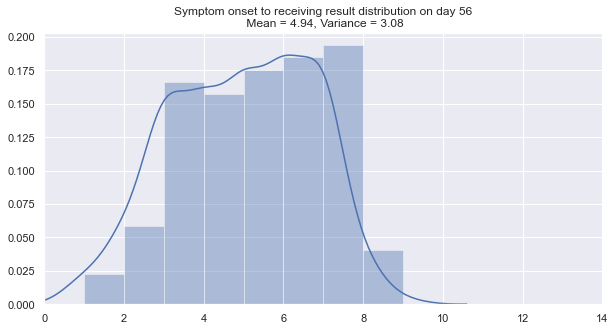

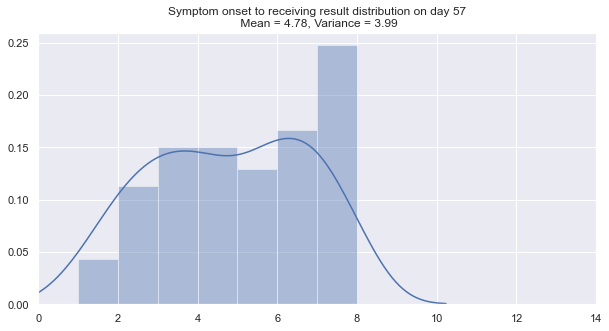

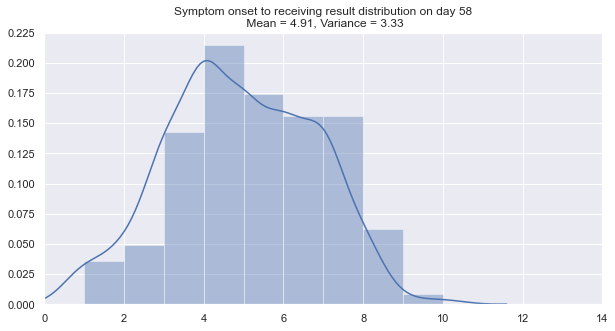

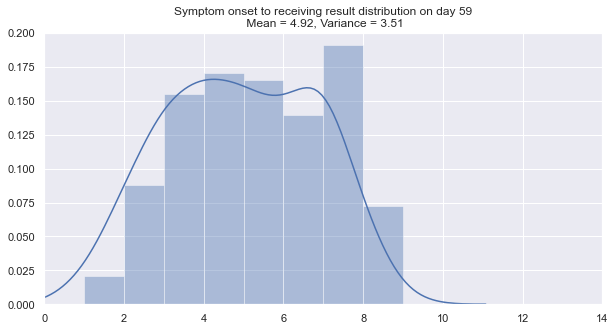

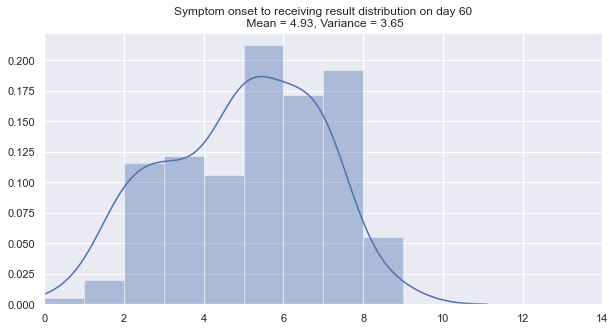

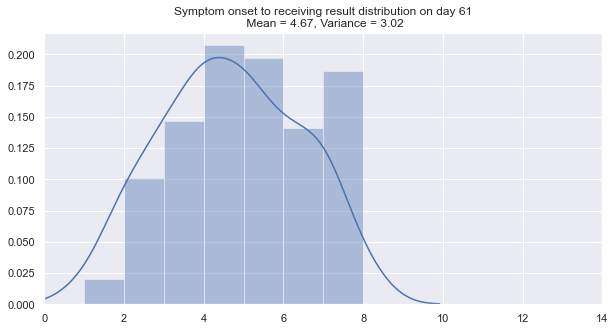

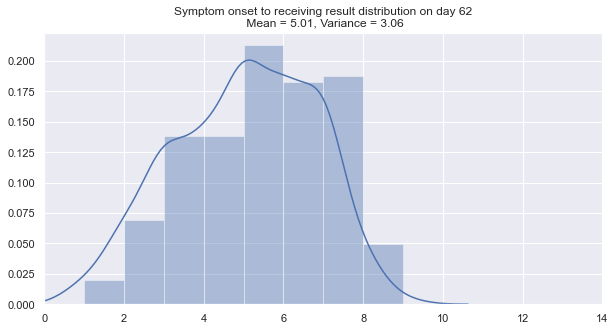

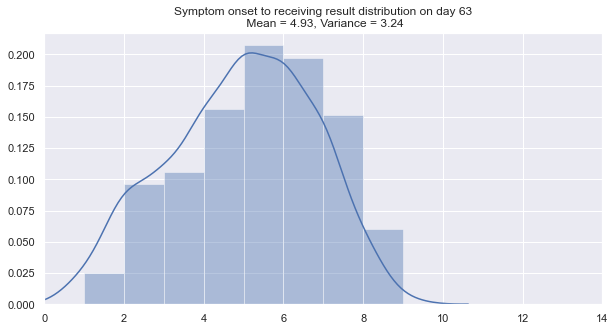

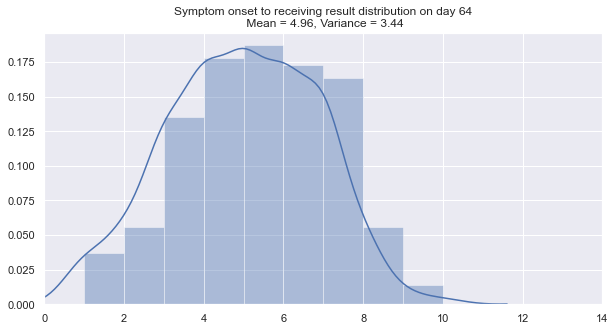

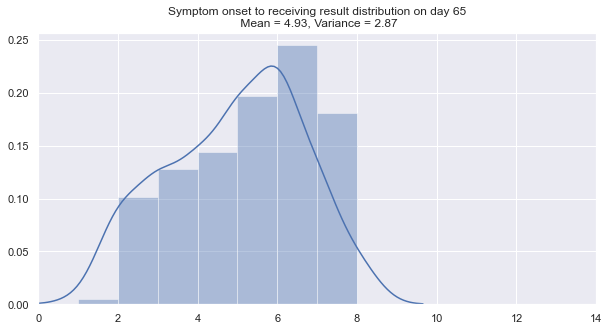

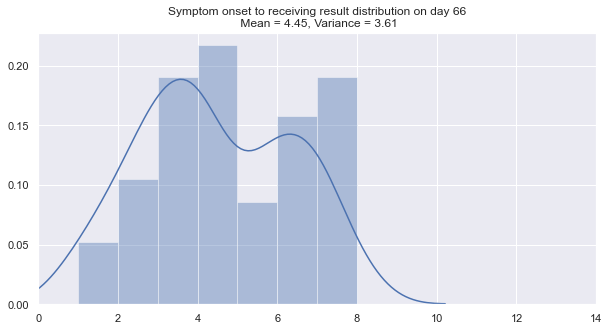

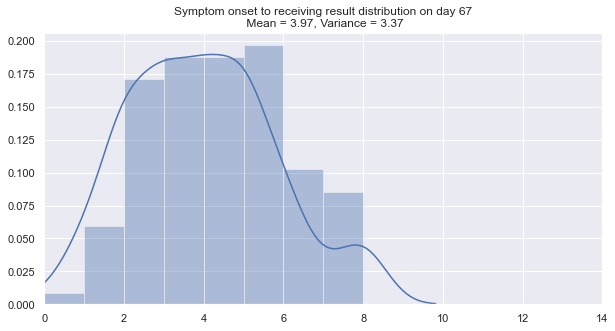

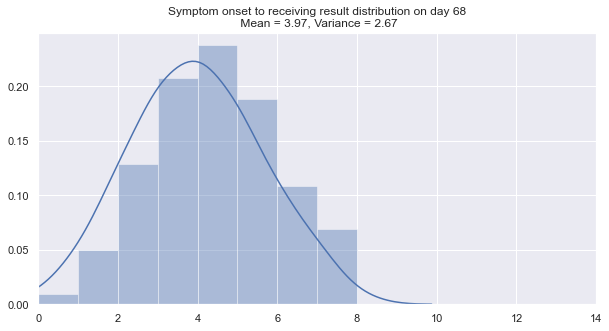

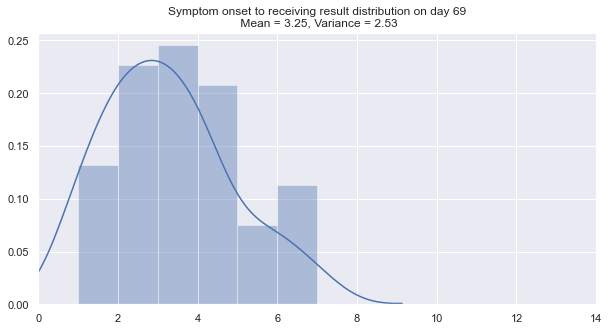

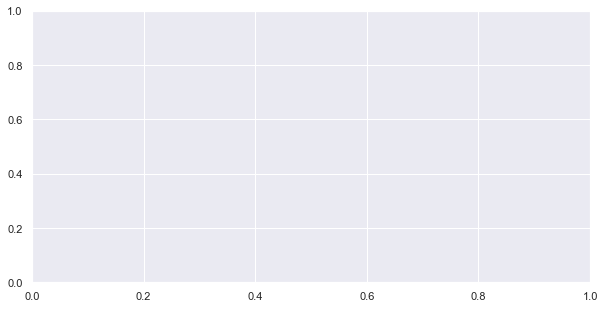

In [12]:
kwargs_write = {'fps':1.0, 'quantizer':'nq'}
imageio.mimsave('./onset_toresult_distribution.gif', [draw_histogram_2(time) for time in range(100)], fps=3)